In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from net import Net
from net2 import Net2
from dataset import create_data_loader, split_train_val, getUpperIndices, addASpace

import os
import string

#to do: 
    #shuffle test and train data
    #see if vocab actually gets updated (it seems to be but i dont believe it!)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#parameters:
numEpochs = 100
batchSize = 1
learningRate = 0.00001

stepSize = 25

paddingValue = 0

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print('device:',device)

device: cpu


In [4]:
vocab = ['_PADDING_']


# Turn string into tensor of ints
def tensorConvert(inp):
    # runtime can be improved if we find a way to convert tensor using tensor / numpy methods of some sort
    # only thing is i wouldnt know how to do this with a vocab though

    inp = inp.translate(str.maketrans('', '', string.punctuation))
    inp = inp.lower()
    
    output = []

    tokenize = inp.split()
    for token in tokenize:
        if token not in vocab:
            vocab.append(token)

        output.append(vocab.index(token))
        
        #print('\nappended',token,'to vocab!')

    output = torch.LongTensor(output)

    return output

In [5]:
#rootdir = 'Data/C50'
rootdir = 'Data/Custom'
#rootdir = 'Data/Custom2'

In [6]:
# get list of authors
classes = []

for it in os.scandir(rootdir): #scan subdirectory and append each element to list of classes
    if it.is_dir():
        author = it.path.replace(rootdir + "\\" , '') #remove 'C50train\' from string
        
        #if author == "DarrenSchuettler": #this is an early stop
            #break
            
        classes.append(author) 

print('Num Classes:',len(classes))
print('classes:',classes[0:5])

Num Classes: 2
classes: ['KanyeWest', 'TaylorSwift']


In [7]:
#data:
length = sum([len(files) for r, d, files in os.walk(rootdir)])
print('Number of files:', length) #this is kinda inaccurate now with the extra csvs and main file

data = []

def gatherData(path):
    #0 = train, 1 = test
    address = path

    prelude = len(address)
    
    #statistics:
    wordSum = 0
    maxWord = 0
    minWord = np.inf
    
    for r, d, files in os.walk(address):
        
        #print here to show progress, warning, a shit load of print statements
        
        author = r[(prelude+1):]

        if author == "":
            continue
            
        #EARLY STOP FOR DEVELOPMENT PURPOSES (cuz going through every author takes an ass load time)
        if author == "DarrenSchuettler": #AlexanderSmith
            break
        
        #print('\nr:',r)
        print('\nAuthor:', author)
        ratio = classes.index(author) / len(classes)
        print(round(ratio * 100,2), '% there.')

        for file in files:
            address = r + '/' + file
            
            #print(address)

            with open(address, 'r', encoding="utf8") as f:
                content = f.read()

            convert = tensorConvert(content)
            
            #print('vocab length:',len(vocab))
            #print('sample:',convert[:5])
            
            authorIdx = classes.index(author)
            
            item = [authorIdx, convert]
            
            data.append(item)
            
            wordCount = list(convert.shape)[0]
            wordSum += wordCount
            if maxWord < wordCount:
                maxWord = wordCount
                
            if minWord > wordCount:
                minWord = wordCount
                
    print('\nAverage word count:', round(wordSum / length, 2))
    print('Max word count:',maxWord)
    print('Min word count:',minWord)
                

Number of files: 253


In [8]:
gatherData(rootdir)


Author: KanyeWest
0.0 % there.

Author: TaylorSwift
50.0 % there.

Average word count: 429.04
Max word count: 2705
Min word count: 41


In [9]:
print(data[0])

#for item in data:
    #print(item[0])

[0, tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,   2,  12,  13,
          8,  14,   5,  15,  16,  17,  18,  19,  20,  18,  21,   5,  22,  20,
         18,  21,  23,  24,  18,  25,  26,  27,   7,   8,  28,  29,  30,  31,
         15,  32,  33,  15,  32,  34,  15,  32,  35,  36,  37,  38,  39,  14,
         40,  14,  41,  26,  42,  43,  44,  45,  23,  46,  47,  48,   8,  26,
         49,  48,  50,  44,  51,  52,  10,  18,  53,  54,  55,  56,  57,  58,
         59,  60,   8,  61,  62,  18,  63,  64,  56,  10,  65,  44,  45,  66,
         67,  10,  23,  68,  69,  23,  70,  15,  66,  71,  72,  73,  23,  74,
         18,  75,  27,   5,  76,  77,  78,  79,  23,  80,  81,  69,  82,  83,
         56,  51,  52,  84,  85,  86,  52,   1,   2,   3,   4,   5,   6,   7,
          8,   9,  10,  11,   2,  12,  13,   8,  14,   5,  15,  16,  17,  18,
         19,  20,  18,  21,   5,  22,  20,  18,  21,  23,  24,  18,  25,  26,
         27,   7,   8,  28,  18,  87,  23,  88,  89,  30,  9

In [10]:
#find maxLength for padding purposes
maxLength = 0

for item in data:
    tensor = item[1]
    length = len(tensor)
    if length > maxLength:
        maxLength = length
        
print(maxLength)
print(len(data[0][1]))

2705
486


In [11]:
def padTensor(tensor):
    length = len(tensor)

    pad = torch.ones((maxLength - length,))
    pad = pad * paddingValue
    #print('pad:',pad)

    newTensor = torch.cat((tensor, pad),0)
    
    return newTensor
    
for item in data:
    tensor = item[1]
    newTensor = padTensor(tensor)
    
    item[1] = newTensor

item = data[0]
print(item)


[0, tensor([1., 2., 3.,  ..., 0., 0., 0.])]


In [12]:
#Split the dataset
trainData, valData, testData = split_train_val(data, props=[0.8, 0.1, 0.1])

print('Length of data:', len(data))
print('Length of partitions:',len(trainData), len(valData), len(testData))
print('Sum:',len(trainData) + len(valData) + len(testData))



Length of data: 253
Length of partitions: 202 25 26
Sum: 253


In [13]:
trainLoader = create_data_loader(trainData, 
                                      batchSize,
                                      shuffle=True)
valLoader = create_data_loader(valData, 
                                    batchSize,
                                    shuffle=True)
testLoader = create_data_loader(testData, 
                                    batchSize,
                                    shuffle=True)

next(iter(trainLoader))

{'input': tensor([[1299., 1495.,   15.,  ...,    0.,    0.,    0.]]),
 'target': tensor([1])}

In [14]:
#insert model here, need to get numbers for these
#inputSize = len(vocab) #not sure if its supposed to be maxLength or len(vocab)
inputSize = maxLength
hiddenSize = 512
outputSize = len(classes)

#net = Net(inputSize, hiddenSize, outputSize).to(device)
net = Net2(inputSize, hiddenSize, outputSize).to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss() #apparently NLL is good for multiclass classification

optimizer = optim.AdamW(net.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= stepSize, gamma=0.1)

print('inputSize:',inputSize)

inputSize: 2705


In [15]:
trainAcc = []
trainLoss = []

validAcc = []
validLoss = []

In [16]:
#start training + print accuracy
#i see no reason to split any of this up into multiple cells but feel free to do so if there is one

#xLen = next(iter(trainLoader))['input'].shape[1]
xLen = 1

hidden = net.init_hidden(xLen)

min_valid_loss = np.inf

for e in range(numEpochs):
    #training loop
    train_loss = 0.0
    correct = 0
    total = 0
    
    net.train()
    
    for item in trainLoader:
        data = item['input']
        label = item['target']

        #print('label:',label)
        
        data, label = data.to(device), label.to(device)
        
        #data = data.long()
        #label = label.long()
        
        optimizer.zero_grad()
        output, hidden = net(data, hidden)
        
        hidden = hidden.detach()
        #output = net(data)
        
        #print('output:',output)
        #print('output shape:',output.shape)
        
        #print('output:',torch.unsqueeze(output[0], 0))
        #print('output shape:',torch.unsqueeze(output[0], 0).shape)
        
        #output = torch.unsqueeze(output[0], 0) 
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        #for accuracy statistics
        prediction = torch.argmax(output)
        total += 1
        
        if label == prediction:
            correct += 1
            
        acc = 100. * correct / total
        
    trainAcc.append(acc)
    trainLoss.append(train_loss)

    #validation loop
    valid_loss = 0.0
    valCorrect = 0
    valTotal = 0
    
    net.eval()  # Optional when not using Model Specific layer
    
    for item in valLoader:
        data = item['input']
        label = item['target']
        
        #print('label:',label)
        
        data, label = data.to(device), label.to(device)
        
        #data = data.long()
        #label = label.long()

        #output = net(data)
        output, hidden = net(data, hidden)
        
        output = torch.unsqueeze(output[0], 0)
        
        loss = criterion(output, label)
        valid_loss = loss.item() * data.size(0)
        
        prediction = torch.argmax(output)
        valTotal += 1
        
        if label == prediction:
            valCorrect += 1
            
        acc = 100. * valCorrect / valTotal
        
    scheduler.step()
        
    validLoss.append(valid_loss)
    validAcc.append(acc)

    print(
        f'\nEpoch {e + 1}: \t Training Loss: {train_loss / len(trainLoader)} \t Validation Loss: {valid_loss / len(valLoader)}')

    #save model if validation loss decreases
    if min_valid_loss > valid_loss:
        print(f'\tValidation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(net.state_dict(), 'Models/saved_model.pth')
        
torch.save(net.state_dict(), 'Models/saved_model_end.pth')



Epoch 1: 	 Training Loss: 110.71234809184892 	 Validation Loss: 0.0
	Validation Loss Decreased(inf--->0.000000) 	 Saving The Model

Epoch 2: 	 Training Loss: 64.92538418313765 	 Validation Loss: 1.094471435546875

Epoch 3: 	 Training Loss: 55.332026029024085 	 Validation Loss: 3.2163690185546874

Epoch 4: 	 Training Loss: 32.951431468433746 	 Validation Loss: 0.0

Epoch 5: 	 Training Loss: 32.691499887202795 	 Validation Loss: 0.0

Epoch 6: 	 Training Loss: 18.66932738299417 	 Validation Loss: 0.0

Epoch 7: 	 Training Loss: 20.696997109523945 	 Validation Loss: 0.0

Epoch 8: 	 Training Loss: 10.063433830893715 	 Validation Loss: 0.0

Epoch 9: 	 Training Loss: 11.64911788111866 	 Validation Loss: 0.0

Epoch 10: 	 Training Loss: 8.661130805479546 	 Validation Loss: 10.18889404296875

Epoch 11: 	 Training Loss: 5.000853540596251 	 Validation Loss: 0.0

Epoch 12: 	 Training Loss: 4.060521752748614 	 Validation Loss: 16.189571533203125

Epoch 13: 	 Training Loss: 8.302686991290498 	 Valida

In [17]:
#test loop
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

totalPred = 0
correctPred = 0

with torch.no_grad():
    for item in testLoader:

        data = item['input']
        label = item['target']
        
        #print(label)
        
        output, hidden = net(data, hidden)

        #print('output:',output)
        prediction = torch.argmax(output)

        #print(prediction)
        
        #print('\nlabel:',label)
        #print('prediction:',prediction)
        if label == prediction:
            
            correct_pred[classes[label]] += 1
            correctPred += 1
            
        total_pred[classes[label]] += 1
        totalPred += 1

for classname, correct_count in correct_pred.items():
    if total_pred[classname] == 0:
        continue
    
    accuracy = 100 * float(correct_count) / total_pred[classname]

    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
    
print('\nTotal Accuracy:', round((correctPred / totalPred) * 100, 2),'%')

Accuracy for class KanyeWest is: 91.7 %
Accuracy for class TaylorSwift is: 57.1 %

Total Accuracy: 73.08 %


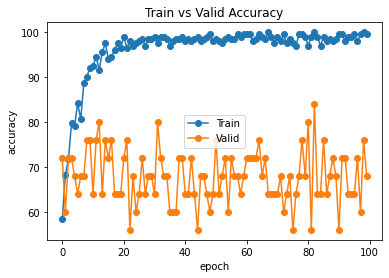

In [18]:
#plot accuracy

plt.plot(trainAcc,'-o')
plt.plot(validAcc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

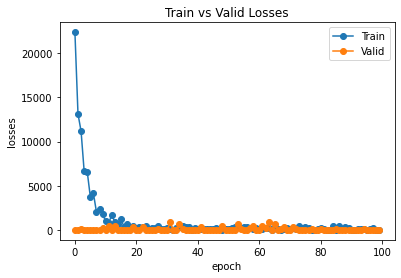

In [19]:
#plot loss

plt.plot(trainLoss,'-o')
plt.plot(validLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()